<a href="https://colab.research.google.com/github/mobraine/Reinforcement-Learning/blob/main/Group_058_Test_Mujoco_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How to train an agent on Mujoco environment**

##**Clone the Project Template Repositeory**

In [ ]:
!git clone https://github.com/COMP579TA/COMP579-Project-Template
%cd COMP579-Project-Template
!conda env create environment.yml -n mujoco
!conda activate mujoco

fatal: destination path 'COMP579-Project-Template' already exists and is not an empty directory.
/content/COMP579-Project-Template
/bin/bash: conda: command not found
/bin/bash: conda: command not found


In [ ]:
import sys
print("User Current Version:-", sys.version)

User Current Version:- 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


## Install the required packages for Mujoco

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.0.0-5).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
libosmesa6-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
software-properties-common is already the newest version (0.96.24.32.18).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
patchelf is already the newest version (0.9-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
!pip install gym
!pip install free-mujoco-py

## Import libraries

In [ ]:
import mujoco_py
import gym
import time
import numpy as np

running build_ext
building 'mujoco_py.cymj' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/mujoco_py -I/usr/local/lib/python3.7/dist-packages/mujoco_py/binaries/linux/mujoco210/include -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I/usr/include/python3.7m -c /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.c -o /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.o -fopenmp -w
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wal

## Create the Hopper environment and run it for an episode

In [ ]:
env = gym.make('Hopper-v2')
env.reset()
acc_reward = 0
done = False
# print(env.action_space)
# print(env.observation_space)
while not done:
  action = env.action_space.sample()
  # print(action)
  obs, reward, done, info = env.step(action)
  # print(obs)
  acc_reward += reward
  # # rendering environment
  # mujoco_py.MjViewer(env.sim).render()
env.close()

print("Episode Ended! Accumulated Reward: {}".format(acc_reward))

Episode Ended! Accumulated Reward: 7.653185397735416


## Define a wrapper for Mujoco environment

In [ ]:
class MujocoEnv(gym.Wrapper):
  '''The Mujoco Environment Wrapper.
     Not to be edited!
  '''

  def __init__(self, env):
    super().__init__(env)
    self.env = env

  def reset(self):
    return self.env.reset()

  def step(self, action):
    next_obs, reward, done, info = self.env.step(action)
    return next_obs, reward, done, info

## Train and evaluate agent

In [ ]:
import gym

import argparse
import importlib
import time
import random
import numpy as np

import tensorflow as tf
import torch

import os
from os import listdir, makedirs
from os.path import isfile, join

def evaluate_agent(agent, env, n_episodes_to_evaluate, seed):
  '''Evaluates the agent for a provided number of episodes.'''

  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  tf.random.set_seed(seed)

  array_of_acc_rewards = []
  for _ in range(n_episodes_to_evaluate):
    acc_reward = 0
    done = False
    curr_obs = env.reset()
    while not done:
      action = agent.act(curr_obs, mode='eval')
      next_obs, reward, done, _ = env.step(action)
      acc_reward += reward
      curr_obs = next_obs
    array_of_acc_rewards.append(acc_reward)
  return np.mean(np.array(array_of_acc_rewards))


def get_environment(env_type):
  '''Generates an environment specific to the agent type.'''
  if 'mujoco' in env_type:
    env = MujocoEnv(gym.make('Hopper-v2'))
  else:
    raise Exception("ERROR: Please define your agent_type to be either a 'JellyBeanAgent' or a 'MujocoAgent'!")
  return env


def train_agent(agent,
                env,
                total_timesteps,
                evaluation_freq,
                n_episodes_to_evaluate,
                seed):

  # seed = 0
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  tf.random.set_seed(seed)

  save_path = '/content/COMP579-Project-Template/GROUP_MJ1/weights.pkl'

  timestep = 0
  array_of_mean_acc_rewards = []
  total_rewards_per_episode = 0
  # print(agent.weights)
  # print(agent.e_t)
  while timestep < total_timesteps:

    done = False
    curr_obs = env.reset()
    print(total_rewards_per_episode)
    total_rewards_per_episode = 0
    while not done:
      action = agent.act(curr_obs, mode='train')
      next_obs, reward, done, _ = env.step(action)
      agent.update(curr_obs, action, reward, next_obs, done, timestep)
      curr_obs = next_obs

      # rendering environment
      # mujoco_py.MjViewer(env.sim).render()

      timestep += 1
      total_rewards_per_episode += reward
      # print(agent.weights)
      # print(agent.e_t)

      if timestep % evaluation_freq == 0:
        mean_acc_rewards = evaluate_agent(agent, env, n_episodes_to_evaluate)
        print(agent.weights)
        print(agent.e_t)
        print('timestep: {ts}, acc_reward: {acr:.2f}'.format(ts=timestep, acr=mean_acc_rewards))
        array_of_mean_acc_rewards.append(mean_acc_rewards)
      if timestep == 15000:
        with open(save_path, 'wb') as f:
          pickle.dump(agent.weights, f)

  return array_of_mean_acc_rewards

## Define the arguments

In [ ]:
class Args:
  group = 'GROUP_MJ1'

## Fill in the functions in Agent class

In [ ]:
import numpy as np
from operator import itemgetter
import pickle
import torch

cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')

class Agent():
  '''The agent class that is to be filled.
     You are allowed to add any method you
     want to this class.
  '''

  def __init__(self, env_specs):
    self.env_specs = env_specs
    self.weights = torch.tensor(np.random.rand(14)).to(device) #torch.tensor(np.zeros(14)).to(device) #np.random.rand(14) # this is state action -value function approximation, np.random.rand(11) is for state value function approximation only ## can be initialized differently, here every individual weight is positive
    self.alpha = 0.0001 # randomly selected, will be updated every step
    self.gamma = 1/3 # randomly selected
    self.tau = 1000 # See RL book p.223, used for setting alpha.
    self.lmda = 0.7 # see lec 11 semi-gradient TD(lambda)
    self.epsilon = 0.1 # for selecting action
    self.e_t = torch.tensor(np.zeros(14)).to(device) # eligibility trace
    self.next_action = None # A' for calculating

    self.feature_ranges = [[-1, 1], [-1, 1], [-1, 1]]  # actions 3 features
    self.number_tilings = 9
    self.bins = [[10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10], [10, 10, 10]]  # each tiling has a 10*10 grid
    self.offsets = [[0, 0, 0], [0.2, 0.2, 0.2], [0.2, -0.2, 0.2], [0.2, 0.2, -0.2], [-0.2, 0.2, 0.2], [-0.2, -0.2, 0.2], [-0.2, 0.2, -0.2], [-0.2, -0.2, -0.2], [0.2, -0.2, -0.2], [10, 10, 10]]
    self.tilings = self.create_tilings(self.feature_ranges, self.number_tilings, self.bins, self.offsets)
    self.acts_tilings = self.get_all_acts_combo(self.tilings)

  def load_weights(self, root_path=None):
    # Add root_path in front of the path of the saved network parameters
    # For example if you have weights.pth in the GROUP_MJ1, do `root_path+"weights.pth"` while loading the parameters

    loaded_weights = None
    save_path = '/content/COMP579-Project-Template/GROUP_MJ1/weights.pkl'
    with open(save_path, 'rb') as f:
      loaded_weights = pickle.load(f)
    self.weights = loaded_weights

  def create_tiling(self, feat_range, bins, offset):
    """
    Create 1 tiling spec of 1 dimension(feature)
    feat_range: feature range; example: [-1, 1]
    bins: number of bins for that feature; example: 10
    offset: offset for that feature; example: 0.2
    """

    # return np.linspace(feat_range[0], feat_range[1], bins+1)[1:-1] + offset
    return np.linspace(feat_range[0], feat_range[1], bins) + offset

  def create_tilings(self, feature_ranges, number_tilings, bins, offsets):
    """
    feature_ranges: range of each feature; example: x: [-1, 1], y: [2, 5] -> [[-1, 1], [2, 5]]
    number_tilings: number of tilings; example: 3 tilings
    bins: bin size for each tiling and dimension; example: [[10, 10], [10, 10], [10, 10]]: 3 tilings * [x_bin, y_bin]
    offsets: offset for each tiling and dimension; example: [[0, 0], [0.2, 1], [0.4, 1.5]]: 3 tilings * [x_offset, y_offset]
    """
    tilings = []
    # for each tiling
    for tile_i in range(number_tilings):
        tiling_bin = bins[tile_i]
        tiling_offset = offsets[tile_i]

        tiling = []
        # for each feature dimension
        for feat_i in range(len(feature_ranges)):
            feat_range = feature_ranges[feat_i]
            # tiling for 1 feature
            feat_tiling = self.create_tiling(feat_range, tiling_bin[feat_i], tiling_offset[feat_i])
            tiling.append(feat_tiling)
        tilings.append(tiling)
    return np.array(tilings)

  # tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)
  def get_all_acts_combo(self, tilings):
    acts_tilings = []
    # for each tiling
    for tile_i in tilings:
      tiling_with_acts_combo = [] # should have 729 elements, given bins=10
      for x in range(tile_i.shape[1]-1):
        for y in range(tile_i.shape[1]-1):
          for z in range(tile_i.shape[1]-1):
            # acts_mean_combo = np.append(np.append((tile_i[0][x] + tile_i[0][x+1])/2, (tile_i[1][y] + tile_i[1][y+1])/2),(tile_i[2][z] + tile_i[2][z+1])/2)
            # acts_range_combo = ((tile_i[0][x], tile_i[0][x+1]),(tile_i[1][y], tile_i[1][y+1]),(tile_i[2][z], tile_i[2][z+1]))

            acts_mean_combo = torch.tensor([(tile_i[0][x] + tile_i[0][x+1])/2, (tile_i[1][y] + tile_i[1][y+1])/2, (tile_i[2][z] + tile_i[2][z+1])/2]).to(device)
            acts_range_combo = torch.tensor([(tile_i[0][x], tile_i[0][x+1]),(tile_i[1][y], tile_i[1][y+1]),(tile_i[2][z], tile_i[2][z+1])]).to(device)

            tiling_with_acts_combo.append((acts_mean_combo, acts_range_combo))
      acts_tilings.append(tiling_with_acts_combo)
    return acts_tilings

  def get_random_greedy_act(self, curr_obs, acts_tilings):
    # max_value_tilings = torch.tensor([]).to(device)
    # max_value_range_tilings = torch.tensor([]).to(device)
    max_value_tilings = []
    max_value_range_tilings = []

    curr_obs = torch.tensor(curr_obs).to(device)

    # for each tiling
    for tile_i in acts_tilings:
      # obs_with_acts = [np.append(curr_obs, acts_mean_combo) for acts_mean_combo, acts_range_combo in tile_i] # should have 729 elements of 14 col, given bins=10
      obs_with_acts = torch.stack([torch.cat((curr_obs, acts_mean_combo)) for acts_mean_combo, acts_range_combo in tile_i]).to(device)
      # print(obs_with_acts.shape)
      # print(self.weights.shape)
      # values_of_obs_with_acts = np.dot(obs_with_acts, self.weights) # should be 729,1
      # max_value_tile_i = np.max(values_of_obs_with_acts)
      values_of_obs_with_acts = torch.matmul(obs_with_acts, self.weights) # should be 729,1
      # print(values_of_obs_with_acts.shape)
      max_value_tile_i = torch.max(values_of_obs_with_acts)
      # print(max_value_tile_i)
      # max_value_acts_range_tile_i = tile_i[np.argmax(values_of_obs_with_acts)][1] # (a1_range, a2_range, a3_range)
      max_value_acts_range_tile_i = tile_i[torch.argmax(values_of_obs_with_acts)][1] # (a1_range, a2_range, a3_range)
      # print(max_value_acts_range_tile_i)
      max_value_tilings.append(max_value_tile_i)
      max_value_range_tilings.append(max_value_acts_range_tile_i)
      # max_value_tilings = torch.tensor((max_value_tilings, max_value_tile_i)).to(device)
      # max_value_range_tilings = torch.tensor(np.concatenate(max_value_range_tilings, max_value_acts_range_tile_i))


    # max_value_acts = max_value_range_tilings[np.argmax(max_value_tilings)]
    # uniform_greedy_action = [np.random.uniform(low=max_value_acts[0][0],high=max_value_acts[0][1]),np.random.uniform(low=max_value_acts[1][0],high=max_value_acts[1][1]),np.random.uniform(low=max_value_acts[2][0],high=max_value_acts[2][1])]
    # print(max_value_range_tilings)
    # print(max_value_tilings)
    max_value_tilings = torch.tensor(max_value_tile_i).to(device)
    # max_value_range_tilings = torch.tensor(max_value_range_tilings).to(device)
    # print(max_value_range_tilings)
    max_value_acts = max_value_range_tilings[torch.argmax(max_value_tilings)]
    # print(max_value_acts)
    # uniform_greedy_action = [np.random.uniform(low=max_value_acts[0][0],high=max_value_acts[0][1]),np.random.uniform(low=max_value_acts[1][0],high=max_value_acts[1][1]),np.random.uniform(low=max_value_acts[2][0],high=max_value_acts[2][1])]
    uniform_greedy_action = [torch.FloatTensor.uniform_(max_value_acts[0][0],max_value_acts[0][1]).tolist(), torch.FloatTensor.uniform_(max_value_acts[1][0],max_value_acts[1][1]).tolist(), torch.FloatTensor.uniform_(max_value_acts[2][0],max_value_acts[2][1]).tolist()]
    # print(uniform_greedy_action)
    return uniform_greedy_action


  def act(self, curr_obs, mode='eval'):
    # 3 types of actions -- 'action space' Box(-1.0, 1.0, (3,), float32),
    # 11 state spaces -- 'observation space' Box(-inf, inf, (11,), float64)

    # epsilon greedy wrt to current state

    # tilings = self.create_tilings(self.feature_ranges, self.number_tilings, self.bins, self.offsets)

    if mode == 'train':
      if np.random.uniform(0.0,1.0) > self.epsilon:
        random_greedy_act = self.get_random_greedy_act(curr_obs, self.acts_tilings)
        return random_greedy_act
      else:
        return self.env_specs['action_space'].sample()

    else: # mode == 'eval'

      random_greedy_act = self.get_random_greedy_act(curr_obs, self.acts_tilings)

      return random_greedy_act


  def update(self, curr_obs, action, reward, next_obs, done, timestep):
    # self.weights = self.weights + (reward - self.Qapproximator(curr_obs, action, self.weights)) * gradient # this is the general approximator

    # rule of thumb for choosing alpha, as recommended for linear SGD on RL book p.223

    sampled_obs = torch.tensor(self.env_specs['observation_space'].sample())
    expect_product_sampled_obs = torch.dot(sampled_obs, sampled_obs) # assume this is a constant.

    # sampled_obs = self.env_specs['observation_space'].sample()
    # expect_product_sampled_obs = np.dot(sampled_obs, sampled_obs) # assume this is a constant.

    self.alpha = 1/(self.tau * expect_product_sampled_obs)

    # Sarsa (lambda) produce MC at one end (lambda = 1) or TD(0) at the other (lambda = 0), see RL book p.287 leave it for now.

    action = torch.tensor(action).to(device)
    curr_obs = torch.tensor(curr_obs).to(device)

    if done:

      # self.e_t = np.concatenate((curr_obs, action)) + self.gamma * self.lmda * self.e_t
      # self.e_t = np.concatenate((curr_obs, action)) + self.e_t

      # self.weights = self.weights + self.alpha * (reward - np.dot(np.concatenate((curr_obs, action)), self.weights)) * self.e_t

      # self.e_t = np.zeros(14) # reset for every episode

      self.e_t = torch.cat((curr_obs, action)).to(device) + self.e_t

      self.weights = self.weights + self.alpha * (reward - torch.dot(torch.cat((curr_obs, action)), self.weights)) * self.e_t

      self.e_t = torch.tensor(np.zeros(14)).to(device) # reset for every episode

    else:
      # self.next_action = self.act(next_obs, 'train') # epsilon greedy wrt to next state

      # delta_t = reward + self.gamma * np.dot(np.concatenate((next_obs, self.next_action)), self.weights) - np.dot(np.concatenate((curr_obs, action)), self.weights)

      # self.weights = self.weights + self.alpha * delta_t * self.e_t

      # self.e_t = self.gamma * self.lmda * self.e_t

      next_obs = torch.tensor(next_obs).to(device)

      self.next_action = torch.tensor(self.act(next_obs, 'train')).to(device) # epsilon greedy wrt to next state

      delta_t = reward + self.gamma * torch.dot(torch.cat((next_obs, self.next_action)), self.weights) - torch.dot(torch.cat((curr_obs, action)), self.weights)

      self.weights = self.weights + self.alpha * delta_t * self.e_t

      self.e_t = self.gamma * self.lmda * self.e_t

    pass

## Load the environment and start training

In [ ]:
if __name__ == '__main__':

  args = Args()
  dir = 'COMP579-Project-Template'
  path = '/content/'+dir+'/'+args.group+'/'
  # path = dir+'/'+args.group+'/'
  files = [f for f in listdir(path) if isfile(join(path, f))]
  if ('agent.py' not in files) or ('env_info.txt' not in files):
    exit()

  with open(path+'env_info.txt') as f:
    lines = f.readlines()
  env_type = lines[0].lower()

  env = get_environment(env_type)
  if 'jellybean' in env_type:
    env_specs = {'scent_space': env.scent_space, 'vision_space': env.vision_space, 'feature_space': env.feature_space, 'action_space': env.action_space}
  if 'mujoco' in env_type:
    env_specs = {'observation_space': env.observation_space, 'action_space': env.action_space}
  # agent_module = importlib.import_module( dir+'.'+args.group+'.agent')
  # agent = agent_module.Agent(env_specs)

  agent = Agent(env_specs)

  total_timesteps = 20000
  evaluation_freq = 1000
  n_episodes_to_evaluate = 20

  # sample efficiency
  list_curves = []
  for seed in range(1,6):
    print(str(seed) + "training...")
    learning_curve = train_agent(agent, env, total_timesteps, evaluation_freq, n_episodes_to_evaluate, seed)
    list_curves.append(learning_curve)
    print(str(seed) + "training done!!!")

  # learning_curve = train_agent(agent, env, total_timesteps, evaluation_freq, n_episodes_to_evaluate)

1training...
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


41.35198192188251
38.786917076766464
41.28100930784431
37.925139305195025
39.9544163730619
38.66816160615669
40.22066768307638
39.78966025552099
38.30772452721506
42.19763068775325
38.63378398578261
38.920437196875476
38.05906834847418
39.03712466992308
39.75747527286933
38.219797043042334
40.342644267206005
38.883786973397505
38.22996739956142
39.019035727666214
38.37324922382211
40.33370186184923
38.810990334744744
40.392683412476686
38.83058248871059
39.735146953922346
39.15131201892891
38.4183168519451
38.8256190144443
38.19990307596913
40.10759711997864
38.53293011384105
41.459884886775875
40.83770730960439
41.43916662359132
38.61814142414388
41.05439331540828
38.616564293461956
40.152209922913215
38.2306443570588
38.680567282604
39.777614964958076
41.86993108541316
39.854293244646215
tensor([ 7.1771e-01, -2.6586e-04,  3.0233e-01,  1.4675e-01,  9.0732e-02,
         1.8419e-01,  3.4407e-01,  3.9326e-01,  5.3806e-01,  4.1903e-01,
         6.8733e-01,  2.0248e-01,  8.7611e-01,  2.535

In [ ]:
print(list_curves)

[[38.612862717762596, 38.95511237676418, 38.848559206408595, 38.81343651928377, 38.74413603528192, 38.57914211574538, 38.71675285133832, 38.61214894118143, 38.65959875553256, 38.80813144518784, 39.03518129991295, 38.64010589794013, 39.02343651515709, 38.789426800744266, 38.62985402652889, 39.00095863315472, 38.80715688041323, 38.56540582230936, 38.48496371841594, 38.456105562909244], [38.78267371127584, 38.68955132121372, 75.47272688902436, 78.55625975210091, 69.34554255577613, 71.1438073798848, 84.89114591460567, 86.20648694409678, 80.0612250143446, 83.86039238600429, 89.33531183319006, 81.57789072591096, 78.04938252120704, 81.92159083361412, 86.3531255847684, 75.2549136097456, 92.96622714125002, 75.80168799574507, 76.01079040168754, 74.17178391355179], [76.29067375594295, 70.2843698231329, 78.98285831271569, 76.58052988177484, 91.38680367096455, 70.31656761071864, 77.87606156923135, 73.08620565915841, 85.59921386052761, 79.61989340699262, 76.39372549032562, 74.9330231352362, 79.62975

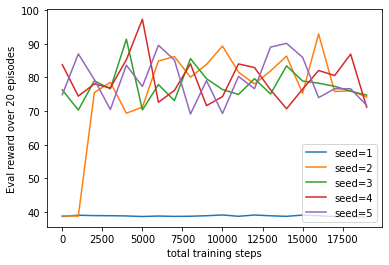

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(0,20000,1000), np.transpose(list_curves))
plt.xlabel('total training steps')
plt.ylabel('Eval reward over 20 episodes')
plt.legend(['seed=1','seed=2','seed=3','seed=4','seed=5'],loc='lower right')


In [ ]:
# Average Performance
agent1 = Agent(env_specs)
agent1.load_weights()
list_performance = []
for seed in range(1,6):
  print(str(seed) + "eval...")
  learning_curve = evaluate_agent(agent1, env, 50, seed)
  list_performance.append(learning_curve)
  print(str(seed) + "eval done!!!")


print(np.mean(list_performance))


1eval...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1eval done!!!
2eval...
2eval done!!!
3eval...
3eval done!!!
4eval...
4eval done!!!
5eval...
5eval done!!!
76.3556224302186


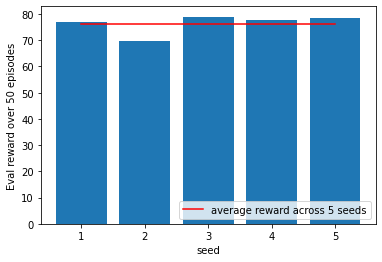

In [ ]:
plt.bar([1,2,3,4,5],list_performance)
plt.xlabel('seed')
plt.ylabel('Eval reward over 50 episodes')
plt.plot([1,2,3,4,5],[np.mean(list_performance)]*5, c='r',label='average reward across 5 seeds')
plt.legend(loc='lower right')



**Once you are done with training the agents, please create an `agent.py` file and `env_info.txt` and upload it to your group folder.**


